In [1]:
import numpy as np
import pandas as pd
import copy
import os 
import pickle
import glmnet
import scipy
import matplotlib
from sklearn.decomposition import PCA
from scripts.utils_ import load_data

from sklearn.manifold import TSNE
from sklearn.covariance import MinCovDet

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
v1_morph = pd.read_csv("./results/classification/two_features_full__res_MC_BC_SC_DBC_BPC_HEC_NFC_alpha_05.csv")
v1_ephys = pd.read_csv("./results/classification/ephys.csv")

del v1_morph['Unnamed: 0']
del v1_ephys['Unnamed: 0']

### get morphology classification data

In [3]:
data_morph = copy.copy(v1_morph)

s='avg_test_score'
p = data_morph.pivot_table(index='group_a', columns='group_b', values=s, fill_value=0)
index = p.index.union(p.columns).values
order = ['BC','DBC','SC','HEC','MC','BPC', 'NFC']
p = p.reindex(index=order, columns=order, fill_value=0)

r = p.values
r_morph = r + r.T
mask_morph = np.zeros_like(p, dtype=np.bool)
mask_morph[np.tril_indices_from(mask_morph)] = True

### get morphology embedding data

In [4]:
files = ['./data/density_map_xz_full.csv', './data/morphometric_statistic_full.csv']

data = pd.read_csv(files[0], index_col='name')
if 'Unnamed: 0' in data.columns:
    data = data.drop('Unnamed: 0', axis=1)
cells = np.array([c[:-4] for c in data.index])
y_morph = data['type'].values.astype(str)

colors = {'BPC':'#808000', 'MC':'#fea400', 'DBC':'#fe00fe', 'HEC':'#32cc32',
          'SC':'#00cdd0', 'PYR':'#000000', 'BC':'#0000fe', 'NFC':'#892be1'}

r2 = scipy.stats.chi2.ppf(.8, 2)

sns.set_style('white')
for i, file in enumerate(files):
    data = pd.read_csv(files[i], index_col='name')
    if 'Unnamed: 0' in data.columns:
        data = data.drop('Unnamed: 0', axis=1)
    index = np.array([c[:-4] for c in data.index])
#     print(index)
    ind = [list(index).index(c) for c in cells]
    data = data.iloc[ind,:]    
    data = data.drop('type', axis=1)
    
    morphFeatures = np.array(data.columns)#[1:]
    X = data.values.astype('float')
        
    Z = X.copy()
    if file.find('morph') > -1: 
#         transf = np.isin(morphFeatures, ['branch_points', 'max_branch_order', 'max_path_dist_to_soma',
#                        'max_segment_length', 'stems', 'tips', 'total_length', 'width'])
#         Z[:, transf] = np.log(Z[:, transf])
        Z = Z[:, (morphFeatures!='min_tortuosity') & (morphFeatures!='min_path_angle')]
        
    Z = Z - Z.mean(axis=0)
    if file.find('morph') > -1:        
        Z = Z / (Z.std(axis=0))

    U,s,V = np.linalg.svd(Z, full_matrices=False)
    Z = U @ np.diag(s)
    Z = Z[:,:10]
    Z = Z / np.std(Z[:,0])
    
            
    if i==0:
        ZZ = Z.copy()
    else:
        ZZ = np.concatenate((ZZ,Z), axis=1)

U,s,V = np.linalg.svd(ZZ, full_matrices=False)
ZZ = U @ np.diag(s)
ZZ_morph = TSNE(perplexity=15, method='exact', random_state=42, early_exaggeration=4).fit_transform(ZZ)

### get ephys classification data

In [5]:
data_ephys = copy.copy(v1_ephys)

data_ephys.loc[data_ephys['group_a'] == 'sBC','group_a'] = 'SC'
data_ephys.loc[data_ephys['group_b'] == 'sBC','group_b'] = 'SC'

data_ephys.loc[data_ephys['group_a'] == 'NFG','group_a'] = 'NFC'
data_ephys.loc[data_ephys['group_b'] == 'NFG','group_b'] = 'NFC'

s='avg_test_score'
p = data_ephys.pivot_table(index='group_a', columns='group_b', values=s, fill_value=0)
index = p.index.union(p.columns).values
order = ['PYR','BC','DBC','SC','HEC','MC','BPC', 'NFC']
p = p.reindex(index=order, columns=order, fill_value=0)

r = p.values
r_ephys = r + r.T
mask_ephys = np.zeros_like(p, dtype=np.bool)
mask_ephys[np.tril_indices_from(mask_ephys)] = True

### get ephys embedding data

In [6]:
ephys = pd.read_csv('./data/ephys/patch-morph-ephys-features.csv', index_col='name sample')
y_ephys = ephys['Cell type'].values.astype(str)
cells_ephys = np.array([c for c in ephys.index])
ind = np.array(ephys.columns)[:-1]
X = ephys.iloc[:,:-1].values.astype('float')

# log transform AI
X[:,np.isin(ind, ['AI (%)'] )] = np.log2(X[:,np.isin(ind, ['AI (%)'] )]/100)

# drop ADP and latency
X = X[:,~np.isin(ind, ['ADP (mV)','Latency (ms)'] )]

In [7]:
XX = X.copy()
XX = XX - XX.mean(axis=0)
XX = XX / XX.std(axis=0)
U,s,V = np.linalg.svd(XX, full_matrices=False)
Z = U @ np.diag(s)

ZZ_ephys = TSNE(perplexity=15, method='exact', random_state=42, early_exaggeration=4).fit_transform(Z)

## Plot figure

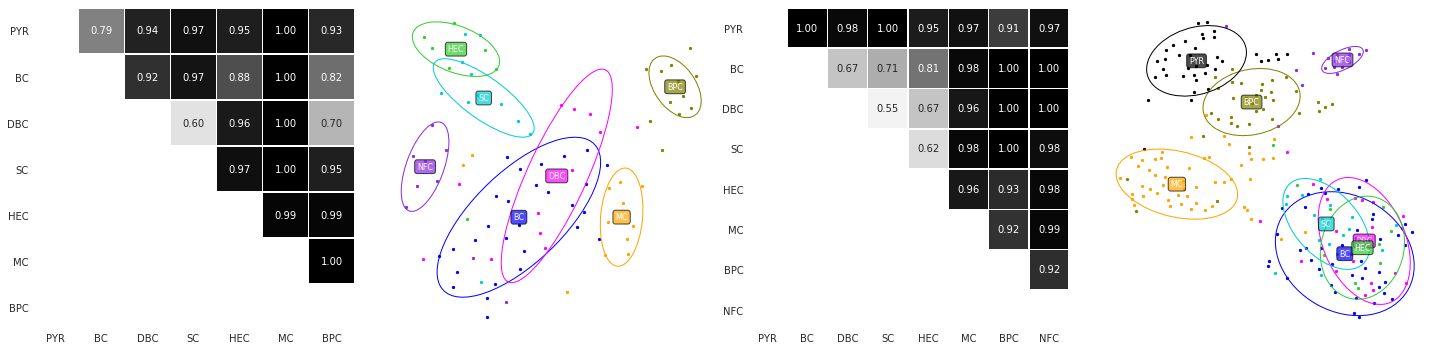

In [9]:
plt.figure(figsize=(20,5))

# plot morphology classification
plt.subplot(1,4,1)
sns.heatmap(r_morph, mask=mask_morph, cmap='Greys', vmin=.5, vmax=1, center=.75, square=True, linewidths=.5,
                   cbar=False, annot=True,fmt='.2f')
plt.gca().set_xticklabels(order, rotation=0)
plt.xlabel('')
plt.gca().set_yticklabels(order, rotation=0)
plt.ylabel('')
plt.gca().tick_params(axis='both', which='both', length=0)


# plot morphology embedding

plt.subplot(1,4,2)

labels, yy = np.unique(y_morph, return_inverse=True)
labels[labels=='NFG'] = 'NFC'

for cl in range(labels.size):
    plt.scatter(ZZ_morph[yy==cl,0], ZZ_morph[yy==cl,1], color=colors[labels[cl]], s=5)
plt.gca().get_xaxis().set_ticklabels([])
plt.gca().get_yaxis().set_ticklabels([])

y_morph[y_morph=='NFG'] = 'NFC'
offsets={'NFC':(8,2), 'BPC':(10,5), 'MC':(8,5), 'SC':(12,3), 'DBC':(2,0)}

# draw ellipses
for cl,l in enumerate(labels):
    mcd = MinCovDet().fit(ZZ_morph[yy==cl,:])
    mu = mcd.location_          # np.mean(ZZ[yy==cl,:], axis=0)
    Sigma = mcd.covariance_     # np.cov(ZZ[yy==cl,:], rowvar=False)

    val, vec = np.linalg.eigh(Sigma)
    width, height = 2 * np.sqrt(val[:, None] * r2)
    theta = np.degrees(np.arctan2(*vec[::-1, 0]))
    ellip = matplotlib.patches.Ellipse(xy=mu, width=width, height=height, angle=theta, 
                                       edgecolor=colors[l], linewidth=1, facecolor='none')
    plt.gca().add_artist(ellip)        
    props = dict(boxstyle='round', facecolor=colors[l], edgecolor=None, alpha=0.7)
    plt.text(mu[0], mu[1], labels[cl], color='white', fontsize=8, ha='center', va='center', bbox=props)

plt.tight_layout()
sns.despine(left=True, bottom=True)


# plot ephys classification
plt.subplot(1,4,3)
sns.heatmap(r_ephys, mask=mask_ephys, cmap='Greys', vmin=.5, vmax=1, center=.75, square=True, linewidths=.5,
                   cbar=False, annot=True,fmt='.2f')
plt.gca().set_xticklabels(order, rotation=0)
plt.xlabel('')
plt.gca().set_yticklabels(order, rotation=0)
plt.ylabel('')
plt.gca().tick_params(axis='both', which='both', length=0)


# plot ephys embedding
plt.subplot(1,4,4)

labels, yy = np.unique(y_ephys, return_inverse=True)
labels[labels=='NFG'] = 'NFC'

for cl in range(labels.size):
    plt.scatter(ZZ_ephys[yy==cl,0], ZZ_ephys[yy==cl,1], color=colors[labels[cl]], s=5)
plt.gca().get_xaxis().set_ticklabels([])
plt.gca().get_yaxis().set_ticklabels([])

y_ephys[y_ephys=='NFG'] = 'NFC'
offsets={'NFC':(8,2), 'BPC':(10,5), 'MC':(8,5), 'SC':(12,3), 'DBC':(2,0)}

# draw ellipses
for cl,l in enumerate(labels):
    mcd = MinCovDet().fit(ZZ_ephys[yy==cl,:])
    mu = mcd.location_          # np.mean(ZZ[yy==cl,:], axis=0)
    Sigma = mcd.covariance_     # np.cov(ZZ[yy==cl,:], rowvar=False)

    val, vec = np.linalg.eigh(Sigma)
    width, height = 2 * np.sqrt(val[:, None] * r2)
    theta = np.degrees(np.arctan2(*vec[::-1, 0]))
    ellip = matplotlib.patches.Ellipse(xy=mu, width=width, height=height, angle=theta, 
                                       edgecolor=colors[l], linewidth=1, facecolor='none')
    plt.gca().add_artist(ellip)        
    props = dict(boxstyle='round', facecolor=colors[l], edgecolor=None, alpha=0.7)
    plt.text(mu[0], mu[1], labels[cl], color='white', fontsize=8, ha='center', va='center', bbox=props)

plt.tight_layout()
sns.despine(left=True, bottom=True)

plt.savefig('./pics/paper/figure2.svg')
plt.savefig('./pics/paper/figure2.png')